In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def load_dataframe(path):
    classes = os.listdir(path)
    df = pd.DataFrame()
    
    for cls in classes:
        cls_path = os.path.join(path, cls)
        
        if not os.path.isdir(cls_path):
            continue
            
        for file in os.listdir(cls_path):
            image_path = os.path.join(path, cls, file)
            
            if os.path.isfile(image_path):
                image = Image.open(image_path)
                image = np.asarray(image, dtype=np.double)
                image_norm = np.linalg.norm(image)
                if image_norm == 0:
                    continue
                image /= image_norm
                df = df.append(pd.Series({'emotion': cls, 'image': image}), ignore_index=True)
    
    return df

In [3]:
df_train = load_dataframe('data/train')
df_test = load_dataframe('data/test')

In [4]:
df_train.shape

(28698, 2)

In [5]:
df_train['emotion'].value_counts()

happy       7214
neutral     4964
sad         4829
fear        4097
angry       3988
surprise    3170
disgust      436
Name: emotion, dtype: int64

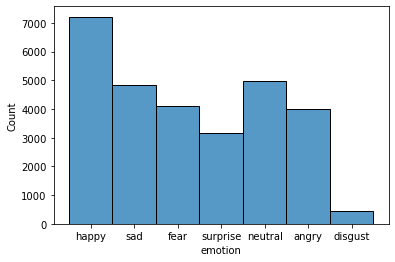

In [6]:
sns.histplot(df_train['emotion']);

In [7]:
df_train.head()

,emotion,image
0,happy,"[[0.01421789994803077, 0.010926719404505129, 0..."
1,happy,"[[0.02488443093438858, 0.02579262184440276, 0...."
2,happy,"[[0.013410307513627045, 0.017880410018169392, ..."
3,happy,"[[0.0178449442522358, 0.01843583644601844, 0.0..."
4,happy,"[[0.03942936717061669, 0.029731014761715004, 0..."


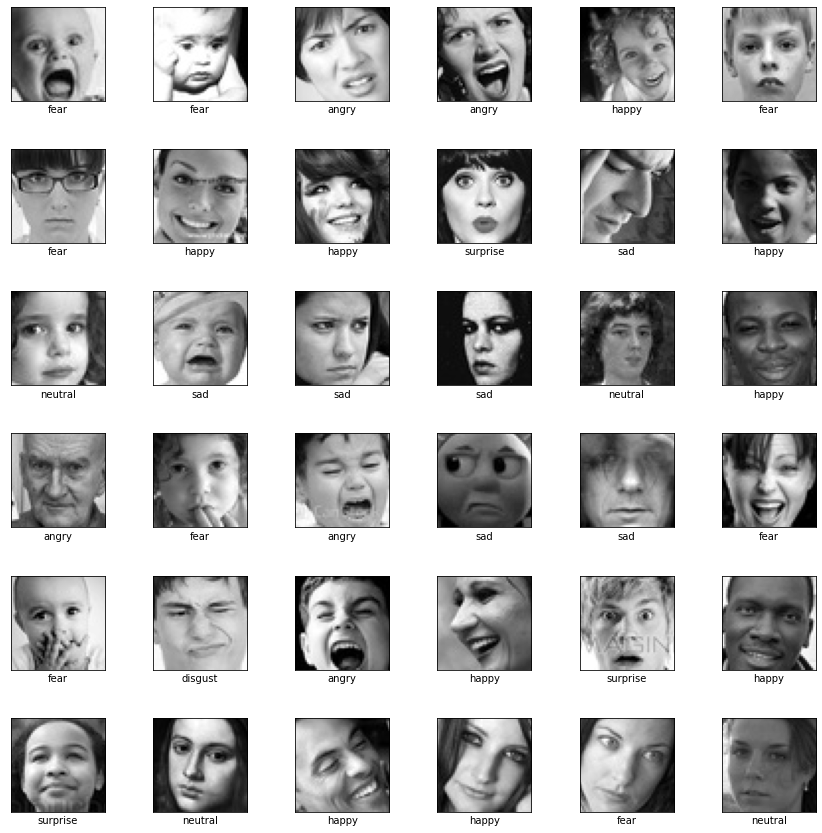

In [8]:
def plot_as_images(rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    fig.tight_layout()
    
    for i in range(rows):
        for j in range(cols):
            index = np.random.choice(np.arange(len(df_train)))
            axes[i,j].imshow(df_train.image[index], cmap="gray")
            axes[i,j].set_xlabel(df_train.emotion[index])
            axes[i,j].get_yaxis().set_visible(False)
            axes[i,j].set_xticks([])

plot_as_images(6, 6)

In [9]:
nclasses = df_train.emotion.nunique()
img_size = df_train.image[0].shape[0]

In [37]:
emotions = df_train.emotion.unique()
emotions_map = {emotion: i for i, emotion in enumerate(emotions)}
emotions_map

{'happy': 0,
 'sad': 1,
 'fear': 2,
 'surprise': 3,
 'neutral': 4,
 'angry': 5,
 'disgust': 6}

In [10]:
def preprocess_dataframe(df):    
    X = np.stack(df.image.apply(lambda img: img.reshape(img_size * img_size, order='F')).values)
    y = df.emotion.apply(lambda emo: emotions_map[emo])
    
    return X, y

In [11]:
X_train, y_train = preprocess_dataframe(df_train)
X_train.shape, y_train.shape

((28698, 2304), (28698,))

In [32]:
from sklearn.linear_model import LogisticRegression

In [69]:
clf = LogisticRegression(fit_intercept=True, multi_class='auto', penalty='l2', solver='saga').fit(X_train, y_train)

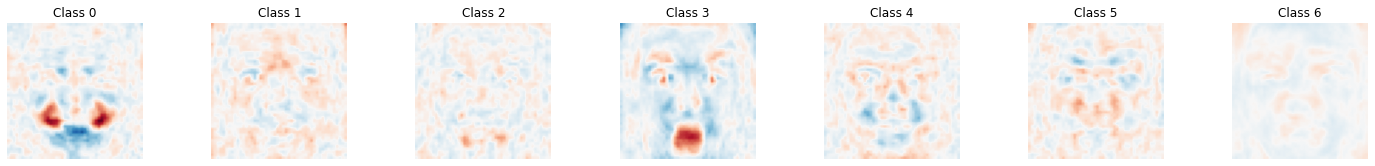

In [73]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 2.5));

for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(img_size, img_size, order='F'),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('Class %i' % i);

In [18]:
from sklearn.metrics import accuracy_score
X_test, y_test = preprocess_dataframe(df_test)

In [72]:
accuracy_score(clf.predict(X_test), y_test)
#accuracy_score(np.argmax(clf.predict_proba(X_test), axis=1), y_test)

0.36324369513724397

In [40]:
from sklearn.model_selection import GridSearchCV

In [67]:
def get_best_params(X, y):
    params = {'penalty': ['l1', 'l2', 'elasticnet'], 'tol': np.linspace(1e-14, 0.1, 5), 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}
    clf = GridSearchCV(LogisticRegression(), params)
    clf.fit(X, y)
    return clf.best_params_

In [74]:
from sklearn.decomposition import PCA

In [77]:
pca = PCA(n_components=30, svd_solver='randomized').fit(X_train)

In [80]:
pca.components_.shape

(30, 2304)

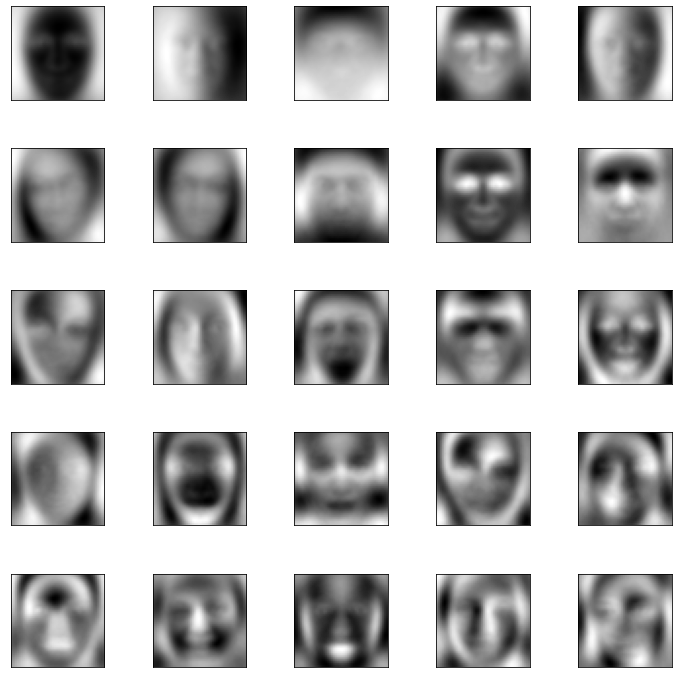

In [91]:
rows = cols = int(np.sqrt(pca.n_components_))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
fig.tight_layout()

for i in range(rows):
    for j in range(cols):
        axes[i,j].imshow(pca.components_[i * cols + j].reshape(img_size, img_size, order='F'), cmap='gray')
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_xticks([])
        